In [2]:
import pandas as pd
import os
import glob

# Path to folder
folder_path = "amrfinder_results"

# Get all TSV files
tsv_files = glob.glob(os.path.join(folder_path, "*.tsv"))

print("Number of AMRFinder files found:", len(tsv_files))

# Read and combine
amr_list = []

for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    
    # Extract genome name from filename
    genome_name = os.path.basename(file).replace(".tsv", "")
    df["genome"] = genome_name
    
    amr_list.append(df)

# Concatenate
amr_raw = pd.concat(amr_list, ignore_index=True)

print("Total AMR hits:", amr_raw.shape[0])
print(amr_raw.head())


Number of AMRFinder files found: 839
Total AMR hits: 6883
       Protein id Element symbol  \
0  IMCFBBLF_02556          pbp2m   
1  IMCFBBLF_02570      aac(3)-XI   
2  IMCFBBLF_02575          aadA1   
3  IMCFBBLF_02576     aac(6')-Ia   
4  IMCFBBLF_02599         tet(W)   

                                        Element name Scope Type Subtype  \
0                   penicillin-binding protein PBP2M  core  AMR     AMR   
1       aminoglycoside N-acetyltransferase AAC(3)-XI  core  AMR     AMR   
2  ANT(3'')-Ia family aminoglycoside nucleotidylt...  core  AMR     AMR   
3   aminoglycoside 6'-N-acetyltransferase AAC(6')-Ia  core  AMR     AMR   
4  tetracycline resistance ribosomal protection p...  core  AMR     AMR   

            Class        Subclass  Method Target length  \
0     BETA-LACTAM     BETA-LACTAM  BLASTP           593   
1  AMINOGLYCOSIDE  AMINOGLYCOSIDE  EXACTP           148   
2  AMINOGLYCOSIDE    STREPTOMYCIN  BLASTP           291   
3  AMINOGLYCOSIDE  AMINOGLYCOSIDE  EXA

In [3]:
print(amr_raw.columns)


Index(['Protein id', 'Element symbol', 'Element name', 'Scope', 'Type',
       'Subtype', 'Class', 'Subclass', 'Method', 'Target length',
       'Reference sequence length', '% Coverage of reference',
       '% Identity to reference', 'Alignment length',
       'Closest reference accession', 'Closest reference name',
       'HMM accession', 'HMM description', 'genome'],
      dtype='str')


In [4]:
amr_df = amr_raw[[
    "Protein id",
    "Element symbol",
    "Element name",
    "Class",
    "Subclass",
    "genome"
]].copy()

amr_df = amr_df.rename(columns={
    "Protein id": "protein_id",
    "Element symbol": "gene_symbol",
    "Element name": "gene_name",
    "Class": "amr_class",
    "Subclass": "amr_subclass"
})

print("AMR hits after cleaning:", amr_df.shape[0])
amr_df.head()


AMR hits after cleaning: 6883


,protein_id,gene_symbol,gene_name,amr_class,amr_subclass,genome
0,IMCFBBLF_02556,pbp2m,penicillin-binding protein PBP2M,BETA-LACTAM,BETA-LACTAM,GCA_016109815.1_PDT000902817.1_genomic_amrfinder
1,IMCFBBLF_02570,aac(3)-XI,aminoglycoside N-acetyltransferase AAC(3)-XI,AMINOGLYCOSIDE,AMINOGLYCOSIDE,GCA_016109815.1_PDT000902817.1_genomic_amrfinder
2,IMCFBBLF_02575,aadA1,ANT(3'')-Ia family aminoglycoside nucleotidylt...,AMINOGLYCOSIDE,STREPTOMYCIN,GCA_016109815.1_PDT000902817.1_genomic_amrfinder
3,IMCFBBLF_02576,aac(6')-Ia,aminoglycoside 6'-N-acetyltransferase AAC(6')-Ia,AMINOGLYCOSIDE,AMINOGLYCOSIDE,GCA_016109815.1_PDT000902817.1_genomic_amrfinder
4,IMCFBBLF_02599,tet(W),tetracycline resistance ribosomal protection p...,TETRACYCLINE,TETRACYCLINE,GCA_016109815.1_PDT000902817.1_genomic_amrfinder


In [5]:
amr_df = amr_df.drop_duplicates(subset=["protein_id"])

print("Unique AMR protein hits:", amr_df.shape[0])


Unique AMR protein hits: 6883


In [10]:
import pandas as pd
import numpy as np

# Load Rtab
rtab = pd.read_csv("gene_presence_absence.Rtab", sep="\t")

matrix = rtab.iloc[:, 1:]
matrix = (matrix > 0).astype(int)
matrix.index = rtab.iloc[:, 0]

n_genomes = matrix.shape[1]

gene_freq = matrix.sum(axis=1) / n_genomes

structure_df = pd.DataFrame({
    "gene_id": matrix.index,
    "frequency": gene_freq.values
})

def assign_compartment(freq):
    if freq >= 0.95:
        return "Core"
    elif freq >= 0.15:
        return "Shell"
    else:
        return "Cloud"

structure_df["compartment_v2"] = structure_df["frequency"].apply(assign_compartment)

print(structure_df["compartment_v2"].value_counts())


compartment_v2
Cloud    3086
Core     2070
Shell    1205
Name: count, dtype: int64


In [11]:
panaroo_csv = pd.read_csv("gene_presence_absence.csv")

protein_map = []

for _, row in panaroo_csv.iterrows():
    gene_family = row["Gene"]
    
    for value in row[1:]:
        if pd.isna(value):
            continue
        
        # Some cells contain multiple proteins separated by commas
        proteins = str(value).split(",")
        
        for p in proteins:
            p = p.strip()
            if p != "":
                protein_map.append([p, gene_family])

protein_map_df = pd.DataFrame(
    protein_map,
    columns=["protein_id", "gene_id"]
)

print("Total protein mappings:", protein_map_df.shape[0])


/var/folders/35/5gwpxs9d3fv16wjzz1c9rs680000gp/T/ipykernel_96846/2421408017.py:1: DtypeWarning: Columns (0: GCA_000159135.1_ASM15913v1_genomic, 1: GCA_000988225.1_ASM98822v1_genomic, 2: GCA_001053405.1_ASM105340v1_genomic, 3: GCA_001053435.1_ASM105343v1_genomic, 4: GCA_001055405.1_ASM105540v1_genomic, 5: GCA_001058455.1_ASM105845v1_genomic, 6: GCA_001059665.1_ASM105966v1_genomic, 7: GCA_001059955.1_ASM105995v1_genomic, 8: GCA_001076975.1_ASM107697v1_genomic, 9: GCA_002156805.1_ASM215680v1_genomic, 10: GCA_002775055.1_ASM277505v1_genomic, 11: GCA_002804085.1_ASM280408v1_genomic, 12: GCA_002865925.1_ASM286592v1_genomic, 13: GCA_003202245.1_ASM320224v1_genomic, 14: GCA_003202295.1_ASM320229v1_genomic, 15: GCA_003202355.1_ASM320235v1_genomic, 16: GCA_004138065.1_ASM413806v1_genomic, 17: GCA_011682945.1_ASM1168294v1_genomic, 18: GCA_011682965.1_ASM1168296v1_genomic, 19: GCA_011682985.1_ASM1168298v1_genomic, 20: GCA_014610885.1_ASM1461088v1_genomic, 21: GCA_015889045.1_PDT000902873.1_genomic

Total protein mappings: 2218898


In [12]:
amr_mapped = amr_df.merge(
    protein_map_df,
    on="protein_id",
    how="left"
)

print("Unmapped AMR proteins:",
      amr_mapped["gene_id"].isna().sum())


Unmapped AMR proteins: 437


In [13]:
unmapped = amr_mapped[amr_mapped["gene_id"].isna()]

print("Example unmapped AMR protein IDs:")
print(unmapped["protein_id"].head(20))


Example unmapped AMR protein IDs:
0      IMCFBBLF_02556
16     OMKGHCCJ_02555
32     PMDONCHG_00045
37     PMDONCHG_02240
56     PPBHIFLO_02830
63     OLHMGOGI_02667
68     PNJCMILM_02281
69     PNJCMILM_02282
70     PNJCMILM_02284
79     BANKJPFG_02782
80     BANKJPFG_02795
87     BANKJPFG_02816
94     FLOPBLJA_01897
112    FABIDELF_02909
121    LABDMPFI_00059
128    GKIHFBEM_02515
141    KEDABBCO_02675
149    NCMACKAH_02617
161    NCMACKAH_02697
188    BFGJCILK_02550
Name: protein_id, dtype: object


In [14]:
print("Example Panaroo protein IDs:")
print(protein_map_df["protein_id"].head(20))


Example Panaroo protein IDs:
0                                     guaA
1     GMP synthase [glutamine-hydrolyzing]
2                           MBDBMIMB_02340
3                           NHGAFLEG_00669
4                           MEBNCGIM_01863
5                           DHLNJOEP_00647
6                           ODCHEJKH_02440
7                           LDONGKPL_01355
8                           JPAFGBFJ_00956
9                           GBHHKFBO_00155
10                          ACOIGFJL_01730
11                          DNMPBICP_02299
12                          MDHBGBBC_02506
13                          OKGGFNBP_01561
14                          EDGKCJPA_02638
15                          BLNAMDJD_02908
16                          ENAGFJMB_00680
17                          HBIHLJDD_00612
18                          JNNOALJA_02550
19                          CHJNHHDP_00979
Name: protein_id, dtype: str


In [15]:
# How many AMR protein IDs match Panaroo protein IDs?

matches = amr_df["protein_id"].isin(protein_map_df["protein_id"])

print("Total AMR proteins:", len(amr_df))
print("Matched to Panaroo:", matches.sum())
print("Unmatched:", (~matches).sum())


Total AMR proteins: 6883
Matched to Panaroo: 6446
Unmatched: 437


In [16]:
amr_mapped_clean = amr_mapped.dropna(subset=["gene_id"]).copy()

print("Mapped AMR proteins:", amr_mapped_clean.shape[0])


Mapped AMR proteins: 6446


In [17]:
amr_gene_families = amr_mapped_clean[["gene_id", "amr_class"]].drop_duplicates()

print("Unique AMR gene families:", amr_gene_families["gene_id"].nunique())


Unique AMR gene families: 35


In [18]:
amr_structure = amr_gene_families.merge(
    structure_df[["gene_id", "compartment_v2"]],
    on="gene_id",
    how="left"
)

print(amr_structure["compartment_v2"].value_counts())


compartment_v2
Shell    19
Cloud    16
Name: count, dtype: int64


In [19]:
amr_gene_counts = amr_structure.groupby("compartment_v2")["gene_id"].nunique()

total_genes = structure_df["compartment_v2"].value_counts()

amr_fraction = amr_gene_counts / total_genes

print(amr_fraction)


compartment_v2
Cloud    0.005185
Core          NaN
Shell    0.015768
dtype: float64


In [21]:
amr_class_table = pd.crosstab(
    amr_structure["compartment_v2"],
    amr_structure["amr_class"]
)

amr_class_prop = amr_class_table.div(
    amr_class_table.sum(axis=1),
    axis=0
)

# Ensure order
amr_class_prop = amr_class_prop.reindex(["Core", "Shell", "Cloud"], fill_value=0)


print(amr_class_prop)


amr_class       AMINOGLYCOSIDE  BETA-LACTAM  \
compartment_v2                                
Core                  0.000000     0.000000   
Shell                 0.421053     0.052632   
Cloud                 0.500000     0.125000   

amr_class       LINCOSAMIDE/MACROLIDE/STREPTOGRAMIN  PHENICOL  \
compartment_v2                                                  
Core                                       0.000000  0.000000   
Shell                                      0.105263  0.052632   
Cloud                                      0.000000  0.062500   

amr_class       QUATERNARY AMMONIUM  SULFONAMIDE  TETRACYCLINE  
compartment_v2                                                  
Core                       0.000000     0.000000      0.000000  
Shell                      0.105263     0.105263      0.157895  
Cloud                      0.125000     0.000000      0.187500  


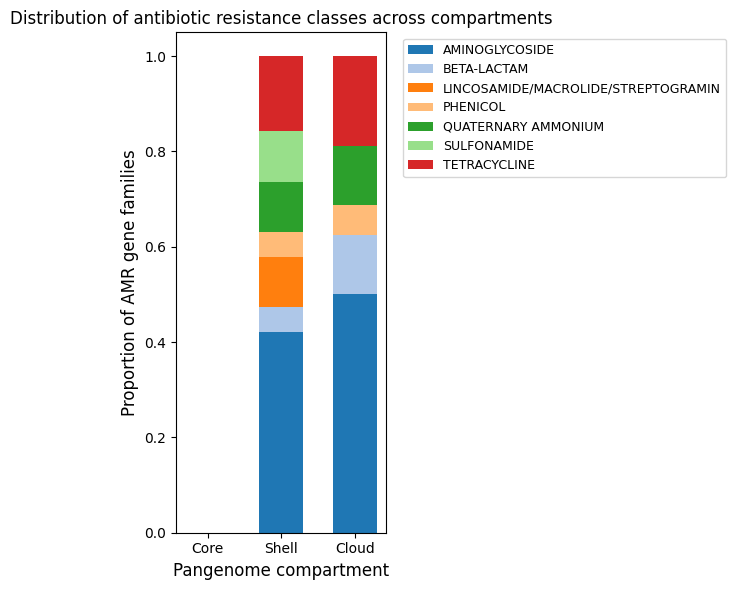

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

categories = amr_class_prop.columns

color_pool = list(chain(
    plt.cm.tab20.colors,
    plt.cm.tab20b.colors,
    plt.cm.tab20c.colors
))

colors = color_pool[:len(categories)]

plt.figure(figsize=(6.5,6))

bottom = np.zeros(len(amr_class_prop))

for i, cat in enumerate(categories):
    values = amr_class_prop[cat].values
    plt.bar(
        amr_class_prop.index,
        values,
        bottom=bottom,
        label=cat,
        color=colors[i],
        width=0.6
    )
    bottom += values

plt.ylabel("Proportion of AMR gene families", fontsize=12)
plt.xlabel("Pangenome compartment", fontsize=12)
plt.title("Distribution of antibiotic resistance classes across compartments")

plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)

plt.tight_layout()

plt.savefig("Figure_7_AMR_class_distribution.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_7_AMR_class_distribution.pdf",
            bbox_inches="tight")

plt.show()


In [23]:
amr_structure.to_csv(
    "Table_AMR_gene_families_with_compartments.csv",
    index=False
)


In [24]:
amr_gene_families.to_csv(
    "Table_AMR_unique_gene_families.csv",
    index=False
)


In [25]:
amr_gene_counts.to_csv(
    "Table_AMR_gene_family_counts_by_compartment.csv"
)


In [26]:
amr_fraction.to_csv(
    "Table_AMR_gene_family_fraction_by_compartment.csv"
)


In [27]:
amr_class_table.to_csv(
    "Table_AMR_class_counts_by_compartment.csv"
)


In [28]:
amr_class_prop.to_csv(
    "Table_AMR_class_proportions_by_compartment.csv"
)


In [29]:
# Get unique AMR gene families
amr_gene_ids = amr_gene_families["gene_id"].unique()

# Subset frequency table
amr_freq_df = structure_df[
    structure_df["gene_id"].isin(amr_gene_ids)
].copy()

print(amr_freq_df.head())


                          gene_id  frequency compartment_v2
2104              carB_4~~~carB_1   0.903456          Shell
2142     mrdA_2~~~mrdA_3~~~mrdA_1   0.842670          Shell
2175                   group_3249   0.769964          Shell
2443  tetM~~~tetW~~~tetO~~~tetW_1   0.442193          Shell
2459                folP~~~folP_2   0.433850          Shell


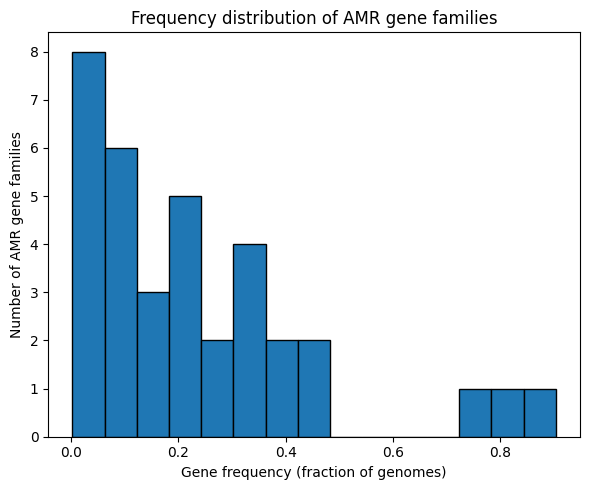

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.hist(
    amr_freq_df["frequency"],
    bins=15,
    edgecolor="black"
)

plt.xlabel("Gene frequency (fraction of genomes)")
plt.ylabel("Number of AMR gene families")
plt.title("Frequency distribution of AMR gene families")

plt.tight_layout()

plt.savefig("Figure_8_AMR_frequency_distribution.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_8_AMR_frequency_distribution.pdf",
            bbox_inches="tight")

plt.show()


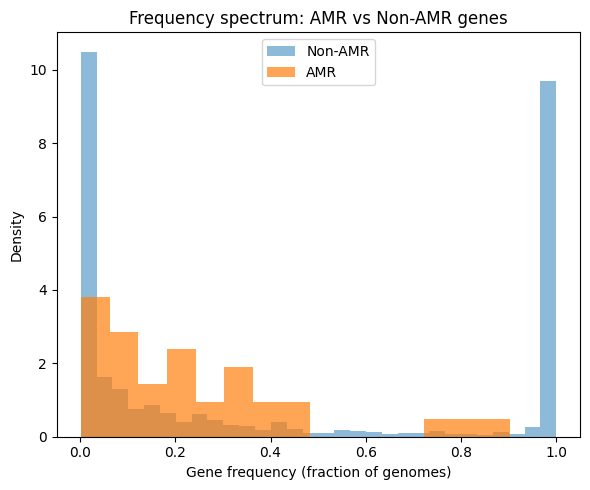

In [31]:
# Non-AMR genes
non_amr_freq = structure_df[
    ~structure_df["gene_id"].isin(amr_gene_ids)
]["frequency"]

plt.figure(figsize=(6,5))

plt.hist(non_amr_freq, bins=30, alpha=0.5, label="Non-AMR", density=True)
plt.hist(amr_freq_df["frequency"], bins=15, alpha=0.7, label="AMR", density=True)

plt.xlabel("Gene frequency (fraction of genomes)")
plt.ylabel("Density")
plt.title("Frequency spectrum: AMR vs Non-AMR genes")
plt.legend()

plt.tight_layout()

plt.savefig("Figure_9_AMR_vs_background_frequency.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_9_AMR_vs_background_frequency.pdf",
            bbox_inches="tight")

plt.show()


In [32]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(
    amr_freq_df["frequency"],
    non_amr_freq,
    alternative="less"
)

print("Mann-Whitney U p-value:", p)


Mann-Whitney U p-value: 0.13562661577292962


In [33]:
import numpy as np

structure_df["is_amr"] = structure_df["gene_id"].isin(amr_gene_ids)

contingency = pd.crosstab(
    structure_df["compartment_v2"],
    structure_df["is_amr"]
)

print(contingency)


is_amr          False  True 
compartment_v2              
Cloud            3070     16
Core             2070      0
Shell            1186     19


In [34]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print("AMR enrichment p-value:", p)


AMR enrichment p-value: 2.8955856973076954e-08


In [35]:
amr_freq_df.to_csv("Table_AMR_gene_family_frequencies.csv", index=False)
contingency.to_csv("Table_AMR_compartment_contingency.csv")


In [37]:
import pandas as pd
import glob
import os

gff_files = glob.glob("gff/*.gff3")

print("Number of GFF files:", len(gff_files))

gff_list = []

for file in gff_files:
    genome = os.path.basename(file).replace(".gff3", "")
    
    with open(file) as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split("\t")
            if len(parts) < 9:
                continue
            if parts[2] != "CDS":
                continue
            
            attributes = parts[8]
            
            # extract ID
            if "ID=" in attributes:
                protein_id = attributes.split("ID=")[1].split(";")[0]
            else:
                continue
            
            # extract product
            product = ""
            if "product=" in attributes:
                product = attributes.split("product=")[1].split(";")[0]
            
            gff_list.append({
                "genome": genome,
                "protein_id": protein_id,
                "product": product
            })

gff_df = pd.DataFrame(gff_list)

print("Total CDS entries:", len(gff_df))
print(gff_df.head())


Number of GFF files: 839
Total CDS entries: 2246034
                                 genome      protein_id  \
0  GCA_047201015.1_ASM4720101v1_genomic  LMCKANAP_00001   
1  GCA_047201015.1_ASM4720101v1_genomic  LMCKANAP_00002   
2  GCA_047201015.1_ASM4720101v1_genomic  LMCKANAP_00003   
3  GCA_047201015.1_ASM4720101v1_genomic  LMCKANAP_00004   
4  GCA_047201015.1_ASM4720101v1_genomic  LMCKANAP_00005   

                                   product  
0            IS3 family transposase IS3501  
1                     hypothetical protein  
2  Transcriptional regulatory protein DegU  
3                     hypothetical protein  
4       Chromosome-partitioning ATPase Soj  


In [38]:
gff_df["product_lower"] = gff_df["product"].str.lower()

mge_keywords = [
    "transposase",
    "integrase",
    "recombinase",
    "insertion sequence",
    "is element",
    "conjugative",
    "mobilization",
    "relaxase"
]

gff_df["is_mge"] = gff_df["product_lower"].apply(
    lambda x: any(k in str(x) for k in mge_keywords)
)

print("Total MGE proteins:", gff_df["is_mge"].sum())


Total MGE proteins: 45097


In [39]:
amr_protein_ids = amr_raw["Protein id"].unique()

gff_df["is_amr"] = gff_df["protein_id"].isin(amr_protein_ids)

print("Total AMR proteins in GFF:", gff_df["is_amr"].sum())


Total AMR proteins in GFF: 6883


In [40]:
gff_df["gene_index"] = gff_df.groupby("genome").cumcount()


In [41]:
window = 10

amr_near_mge = []

for genome, sub in gff_df.groupby("genome"):
    
    amr_positions = sub[sub["is_amr"]]["gene_index"]
    mge_positions = sub[sub["is_mge"]]["gene_index"]
    
    for amr_pos in amr_positions:
        if any(abs(amr_pos - mge_positions) <= window):
            amr_near_mge.append(1)
        else:
            amr_near_mge.append(0)

print("AMR genes near MGE (within 10 genes):", sum(amr_near_mge))
print("Total AMR genes:", len(amr_near_mge))


AMR genes near MGE (within 10 genes): 6421
Total AMR genes: 6883


In [42]:
total_genes = len(gff_df)
total_mge = gff_df["is_mge"].sum()

print("Total genes:", total_genes)
print("Total MGE genes:", total_mge)
print("MGE proportion:", total_mge / total_genes)


Total genes: 2246034
Total MGE genes: 45097
MGE proportion: 0.020078502818746288


In [43]:
for window in [1, 2, 3, 5, 10]:
    count = 0
    
    for genome, sub in gff_df.groupby("genome"):
        amr_positions = sub[sub["is_amr"]]["gene_index"]
        mge_positions = sub[sub["is_mge"]]["gene_index"]
        
        for amr_pos in amr_positions:
            if any(abs(amr_pos - mge_positions) <= window):
                count += 1
    
    print(f"Window ±{window}: {count}")


Window ±1: 2297
Window ±2: 3399
Window ±3: 4109
Window ±5: 5381
Window ±10: 6421


In [44]:
import numpy as np

window = 5  # use moderate window

random_hits = 0
total_random = 0

for genome, sub in gff_df.groupby("genome"):
    
    gene_indices = sub["gene_index"].values
    mge_positions = sub[sub["is_mge"]]["gene_index"]
    
    if len(mge_positions) == 0:
        continue
    
    # randomly sample same number as AMR in this genome
    n_amr = sub["is_amr"].sum()
    
    if n_amr == 0:
        continue
    
    random_positions = np.random.choice(gene_indices, size=n_amr, replace=False)
    
    for pos in random_positions:
        if any(abs(pos - mge_positions) <= window):
            random_hits += 1
    
    total_random += n_amr

print("Random proximity proportion:", random_hits / total_random)


Random proximity proportion: 0.1279965131483365


In [45]:
window = 5

# AMR proximity
amr_near = 5381
amr_far = 6883 - amr_near

# Random expectation scaled to same AMR count
random_near = int(0.1279965131483365 * 6883)
random_far = 6883 - random_near

import numpy as np
from scipy.stats import fisher_exact

contingency = np.array([
    [amr_near, amr_far],
    [random_near, random_far]
])

oddsratio, p = fisher_exact(contingency)

print("Fisher p-value:", p)
print("Odds ratio:", oddsratio)


Fisher p-value: 0.0
Odds ratio: 24.40692924001445


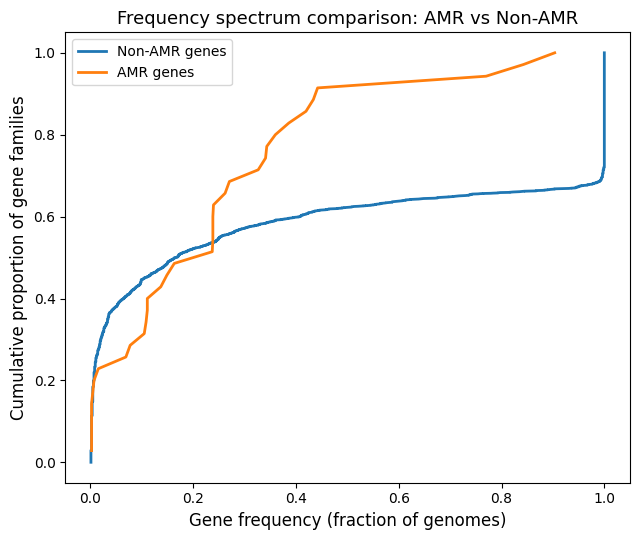

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# AMR frequencies
amr_freq = amr_freq_df["frequency"].values

# Non-AMR frequencies
non_amr_freq = structure_df[
    ~structure_df["gene_id"].isin(amr_gene_ids)
]["frequency"].values

x_amr, y_amr = ecdf(amr_freq)
x_non, y_non = ecdf(non_amr_freq)

plt.figure(figsize=(6.5,5.5))

plt.plot(x_non, y_non, label="Non-AMR genes", linewidth=2)
plt.plot(x_amr, y_amr, label="AMR genes", linewidth=2)

plt.xlabel("Gene frequency (fraction of genomes)", fontsize=12)
plt.ylabel("Cumulative proportion of gene families", fontsize=12)
plt.title("Frequency spectrum comparison: AMR vs Non-AMR", fontsize=13)

plt.legend()
plt.tight_layout()

plt.savefig("Figure_10_AMR_age_ECDF.png", dpi=300, bbox_inches="tight")
plt.savefig("Figure_10_AMR_age_ECDF.pdf", bbox_inches="tight")

plt.show()


In [47]:
windows = [1, 2, 3, 5, 10]

results = []

for window in windows:
    count = 0
    
    for genome, sub in gff_df.groupby("genome"):
        amr_positions = sub[sub["is_amr"]]["gene_index"]
        mge_positions = sub[sub["is_mge"]]["gene_index"]
        
        for amr_pos in amr_positions:
            if any(abs(amr_pos - mge_positions) <= window):
                count += 1
    
    proportion = count / len(amr_protein_ids)
    
    results.append({
        "window": f"±{window}",
        "Observed_AMR": proportion
    })

window_df = pd.DataFrame(results)


In [48]:
import numpy as np

random_results = []

for window in windows:
    random_hits = 0
    total_random = 0
    
    for genome, sub in gff_df.groupby("genome"):
        gene_indices = sub["gene_index"].values
        mge_positions = sub[sub["is_mge"]]["gene_index"]
        
        n_amr = sub["is_amr"].sum()
        if n_amr == 0:
            continue
        
        random_positions = np.random.choice(
            gene_indices,
            size=n_amr,
            replace=False
        )
        
        for pos in random_positions:
            if any(abs(pos - mge_positions) <= window):
                random_hits += 1
        
        total_random += n_amr
    
    random_results.append(random_hits / total_random)

window_df["Random"] = random_results


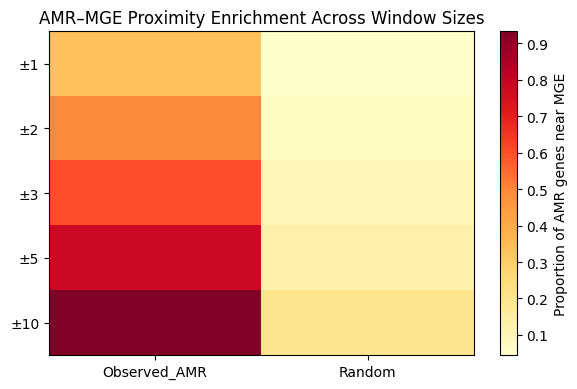

In [49]:
import matplotlib.pyplot as plt

heatmap_matrix = window_df.set_index("window")

plt.figure(figsize=(6,4))

plt.imshow(
    heatmap_matrix,
    aspect="auto",
    cmap="YlOrRd"
)

plt.xticks(
    ticks=range(len(heatmap_matrix.columns)),
    labels=heatmap_matrix.columns
)

plt.yticks(
    ticks=range(len(heatmap_matrix.index)),
    labels=heatmap_matrix.index
)

plt.colorbar(label="Proportion of AMR genes near MGE")

plt.title("AMR–MGE Proximity Enrichment Across Window Sizes")

plt.tight_layout()

plt.savefig("Figure_11_AMR_MGE_proximity_heatmap.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_11_AMR_MGE_proximity_heatmap.pdf",
            bbox_inches="tight")

plt.show()


In [50]:
window = 5

# Compute AMR proximity
amr_near = 5381
amr_far = 6883 - amr_near

# Compute background proximity (using actual genome data)
non_amr_total = len(gff_df) - 6883

# Count non-AMR genes near MGE
non_amr_near = 0

for genome, sub in gff_df.groupby("genome"):
    mge_positions = sub[sub["is_mge"]]["gene_index"]
    
    for idx, row in sub.iterrows():
        if row["is_amr"]:
            continue
        
        if any(abs(row["gene_index"] - mge_positions) <= window):
            non_amr_near += 1

non_amr_far = non_amr_total - non_amr_near

heatmap_data = pd.DataFrame(
    [
        [amr_near / 6883, amr_far / 6883],
        [non_amr_near / non_amr_total, non_amr_far / non_amr_total]
    ],
    index=["AMR", "Non-AMR"],
    columns=["Near MGE", "Far from MGE"]
)


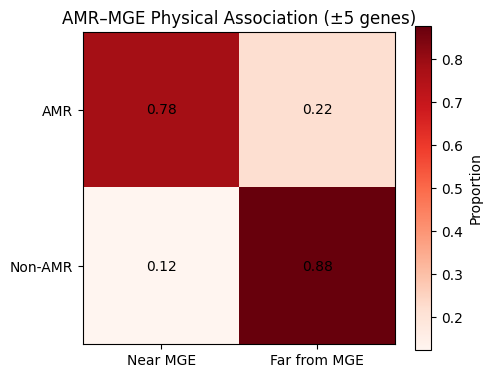

In [54]:
plt.figure(figsize=(5,4))

plt.imshow(heatmap_data, cmap="Reds")

plt.xticks(range(2), heatmap_data.columns)
plt.yticks(range(2), heatmap_data.index)

for i in range(2):
    for j in range(2):
        plt.text(j, i, 
                 f"{heatmap_data.iloc[i,j]:.2f}",
                 ha="center", va="center", color="black")

plt.colorbar(label="Proportion")

plt.title("AMR–MGE Physical Association (±5 genes)")

plt.tight_layout()
plt.show()


In [55]:
import numpy as np

log2_or = np.log2(oddsratio)
print("log2 OR:", log2_or)


log2 OR: 4.6092188886183765


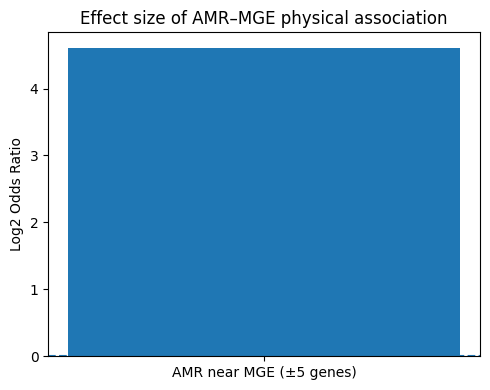

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

plt.bar(
    ["AMR near MGE (±5 genes)"],
    [log2_or],
    width=0.5
)

plt.axhline(0, linestyle="--")

plt.ylabel("Log2 Odds Ratio")
plt.title("Effect size of AMR–MGE physical association")

plt.tight_layout()

plt.savefig("Figure_11_AMR_MGE_log2OR.png", dpi=300, bbox_inches="tight")
plt.savefig("Figure_11_AMR_MGE_log2OR.pdf", bbox_inches="tight")

plt.show()


In [57]:
window = 5

gff_df["near_mge"] = False

for genome, sub in gff_df.groupby("genome"):
    mge_positions = sub[sub["is_mge"]]["gene_index"]
    
    for idx, row in sub.iterrows():
        if any(abs(row["gene_index"] - mge_positions) <= window):
            gff_df.at[idx, "near_mge"] = True


In [58]:
gff_with_comp = gff_df.merge(
    protein_map_df,
    on="protein_id",
    how="left"
).merge(
    structure_df[["gene_id", "compartment_v2"]],
    on="gene_id",
    how="left"
)


In [59]:
triple_table = pd.crosstab(
    gff_with_comp["compartment_v2"],
    [gff_with_comp["is_amr"], gff_with_comp["near_mge"]]
)

# Normalize by compartment size
triple_prop = triple_table.div(
    triple_table.sum(axis=1),
    axis=0
)

print(triple_prop)


is_amr             False               True           
near_mge           False     True      False     True 
compartment_v2                                        
Cloud           0.647178  0.343110  0.003402  0.006310
Core            0.941282  0.058718  0.000000  0.000000
Shell           0.649613  0.335014  0.003054  0.012319


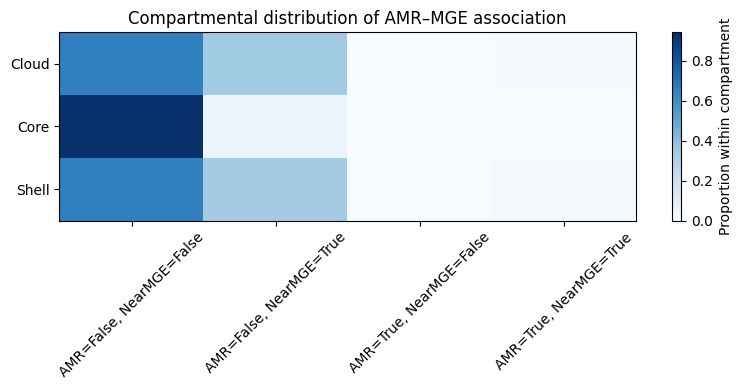

In [60]:
plt.figure(figsize=(8,4))

plt.imshow(triple_prop, cmap="Blues", aspect="auto")

plt.xticks(
    ticks=range(len(triple_prop.columns)),
    labels=[f"AMR={a}, NearMGE={b}" for a,b in triple_prop.columns],
    rotation=45
)

plt.yticks(
    ticks=range(len(triple_prop.index)),
    labels=triple_prop.index
)

plt.colorbar(label="Proportion within compartment")

plt.title("Compartmental distribution of AMR–MGE association")

plt.tight_layout()

plt.savefig("Figure_12_AMR_MGE_compartment_heatmap.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_12_AMR_MGE_compartment_heatmap.pdf",
            bbox_inches="tight")

plt.show()


In [61]:
# Keep only genes with compartment info
subset = gff_with_comp.dropna(subset=["compartment_v2"])

# Build focused crosstab
focus_table = pd.crosstab(
    subset["compartment_v2"],
    subset["is_amr"] & subset["near_mge"]
)

# That gives False / True; we want proportions of True
near_table = pd.crosstab(
    subset["compartment_v2"],
    subset["near_mge"]
)

# Now compute:
# proportion of AMR genes near MGE within compartment
amr_near_by_comp = subset[subset["is_amr"]].groupby(
    "compartment_v2"
)["near_mge"].mean()

# proportion of non-AMR genes near MGE
nonamr_near_by_comp = subset[~subset["is_amr"]].groupby(
    "compartment_v2"
)["near_mge"].mean()

heatmap_df = pd.DataFrame({
    "AMR near MGE": amr_near_by_comp,
    "Non-AMR near MGE": nonamr_near_by_comp
})

heatmap_df = heatmap_df.loc[["Core", "Shell", "Cloud"]]

print(heatmap_df)


                AMR near MGE  Non-AMR near MGE
compartment_v2                                
Core                     NaN          0.058718
Shell               0.801325          0.340245
Cloud               0.649718          0.346475


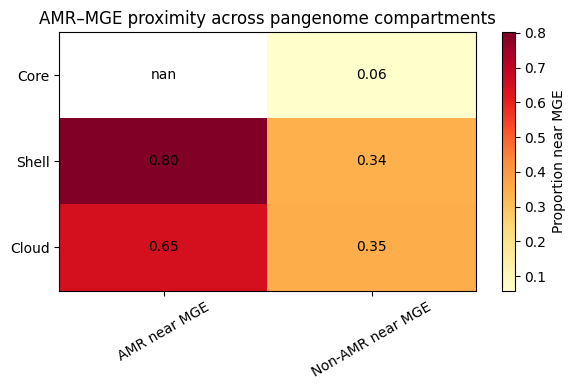

In [62]:
plt.figure(figsize=(6,4))

plt.imshow(heatmap_df, cmap="YlOrRd", aspect="auto")

plt.xticks(
    ticks=range(len(heatmap_df.columns)),
    labels=heatmap_df.columns,
    rotation=30
)

plt.yticks(
    ticks=range(len(heatmap_df.index)),
    labels=heatmap_df.index
)

# Add numbers inside cells
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        plt.text(j, i,
                 f"{heatmap_df.iloc[i,j]:.2f}",
                 ha="center", va="center", color="black")

plt.colorbar(label="Proportion near MGE")

plt.title("AMR–MGE proximity across pangenome compartments")

plt.tight_layout()

plt.savefig("Figure_12_AMR_MGE_compartment_heatmap_clean.png",
            dpi=300, bbox_inches="tight")
plt.savefig("Figure_12_AMR_MGE_compartment_heatmap_clean.pdf",
            bbox_inches="tight")

plt.show()


In [64]:
import pandas as pd
import numpy as np

# Core values
total_amr = 6883
near_mge_10 = 6421
random_mge_prop = 0.1279965131483365
odds_ratio = 24.40692924001445
fisher_p = 0.0

# Calculate percentages
observed_prop = near_mge_10 / total_amr
expected_prop = random_mge_prop

AMR_MGE_association_summary = pd.DataFrame({
    "Metric": [
        "Total AMR genes",
        "AMR near MGE (±10 genes)",
        "Observed proportion near MGE",
        "Expected random proportion",
        "Odds ratio (Fisher)",
        "Fisher exact p-value"
    ],
    "Value": [
        total_amr,
        near_mge_10,
        round(observed_prop, 4),
        round(expected_prop, 4),
        round(odds_ratio, 2),
        fisher_p
    ]
})

AMR_MGE_association_summary


,Metric,Value
0,Total AMR genes,6883.0000
1,AMR near MGE (±10 genes),6421.0000
2,Observed proportion near MGE,0.9329
3,Expected random proportion,0.1280
4,Odds ratio (Fisher),24.4100
5,Fisher exact p-value,0.0000


In [65]:
AMR_MGE_association_summary.to_csv(
    "AMR_MGE_association_summary.csv",
    index=False
)


In [66]:
# Construct contingency table
near_amr = near_mge_10
not_near_amr = total_amr - near_mge_10

total_genes = 2246034
total_mge_genes = 45097

expected_near_random = total_genes * random_mge_prop

contingency_table = pd.DataFrame({
    "Near_MGE": [near_amr, total_mge_genes],
    "Not_Near_MGE": [not_near_amr, total_genes - total_mge_genes]
}, index=["AMR", "Background"])

contingency_table


,Near_MGE,Not_Near_MGE
AMR,6421,462
Background,45097,2200937


In [67]:
contingency_table.to_csv("AMR_MGE_contingency_table.csv")


In [68]:
import pandas as pd
import os
import glob

# Path to mob results
mob_path = os.path.expanduser("~/Downloads/mob_all_839")

records = []

for genome_dir in os.listdir(mob_path):
    genome_path = os.path.join(mob_path, genome_dir)
    
    contig_file = os.path.join(genome_path, "contig_report.txt")
    
    if os.path.exists(contig_file):
        df = pd.read_csv(contig_file, sep="\t")
        
        # Keep only needed columns
        df_subset = df[["contig_id", "molecule_type"]].copy()
        df_subset["genome"] = genome_dir
        
        records.append(df_subset)

plasmid_master = pd.concat(records, ignore_index=True)

plasmid_master.head()


,contig_id,molecule_type,genome
0,DACSDL010000001.1,chromosome,GCA_015892295.1_PDT000902330.1_genomic
1,DACSDL010000002.1,chromosome,GCA_015892295.1_PDT000902330.1_genomic
2,DACSDL010000003.1,chromosome,GCA_015892295.1_PDT000902330.1_genomic
3,DACSDL010000004.1,chromosome,GCA_015892295.1_PDT000902330.1_genomic
4,DACSDL010000005.1,chromosome,GCA_015892295.1_PDT000902330.1_genomic


In [69]:
plasmid_master["molecule_type"].value_counts()


molecule_type
chromosome    92953
plasmid        3748
Name: count, dtype: int64

In [70]:
plasmid_master["genome"].nunique()


839

In [72]:
gff_df.columns


Index(['genome', 'protein_id', 'product', 'product_lower', 'is_mge', 'is_amr',
       'gene_index', 'near_mge'],
      dtype='str')

In [73]:
plasmid_master.columns


Index(['contig', 'molecule_type', 'genome'], dtype='str')

In [88]:
import os
import pandas as pd

gff_path = os.path.expanduser("~/Downloads/gff")

records = []

for file in os.listdir(gff_path):
    if file.endswith(".gff3") or file.endswith(".gff"):
        genome = file.replace(".gff3", "").replace(".gff", "")
        filepath = os.path.join(gff_path, file)
        
        with open(filepath) as f:
            for line in f:
                if not line.startswith("#"):
                    parts = line.strip().split("\t")
                    
                    if len(parts) >= 9 and parts[2] == "CDS":
                        contig = parts[0]
                        attributes = parts[8]
                        
                        if "ID=" in attributes:
                            protein_id = attributes.split("ID=")[1].split(";")[0]
                            
                            records.append({
                                "genome": genome,
                                "protein_id": protein_id,
                                "contig": contig
                            })

gff_contig_map = pd.DataFrame(records)

gff_contig_map.shape


(2246034, 3)

In [89]:
gff_contig_map["genome"].nunique()


839

In [90]:
gff_df = gff_df.merge(
    gff_contig_map,
    on=["genome", "protein_id"],
    how="left"
)

gff_df["contig"].isna().sum()


np.int64(0)

In [91]:
gff_with_plasmid = gff_df.merge(
    plasmid_master,
    on=["genome", "contig"],
    how="left"
)

# Check distribution
gff_with_plasmid["molecule_type"].value_counts()


molecule_type
chromosome    2232105
plasmid         13929
Name: count, dtype: int64

In [92]:
total_amr = gff_with_plasmid["is_amr"].sum()

amr_plasmid = gff_with_plasmid[
    (gff_with_plasmid["is_amr"]) &
    (gff_with_plasmid["molecule_type"] == "plasmid")
].shape[0]

amr_chrom = gff_with_plasmid[
    (gff_with_plasmid["is_amr"]) &
    (gff_with_plasmid["molecule_type"] == "chromosome")
].shape[0]

print("Total AMR genes:", total_amr)
print("AMR on plasmids:", amr_plasmid)
print("AMR on chromosomes:", amr_chrom)
print("Percent plasmid-borne:", round(100 * amr_plasmid / total_amr, 2), "%")


Total AMR genes: 6883
AMR on plasmids: 4409
AMR on chromosomes: 2474
Percent plasmid-borne: 64.06 %


In [93]:
from scipy.stats import fisher_exact

# Total genes
total_genes = gff_with_plasmid.shape[0]

# Total plasmid genes
total_plasmid_genes = gff_with_plasmid[
    gff_with_plasmid["molecule_type"] == "plasmid"
].shape[0]

# Build contingency table
a = amr_plasmid
b = amr_chrom
c = total_plasmid_genes - amr_plasmid
d = (total_genes - total_plasmid_genes) - amr_chrom

oddsratio, pvalue = fisher_exact([[a, b], [c, d]])

print("Fisher p-value:", pvalue)
print("Odds ratio:", oddsratio)


Fisher p-value: 0.0
Odds ratio: 417.38462696921937


In [94]:
total_genes = gff_with_plasmid.shape[0]
total_plasmid_genes = gff_with_plasmid[
    gff_with_plasmid["molecule_type"] == "plasmid"
].shape[0]

print("Total genes:", total_genes)
print("Total plasmid genes:", total_plasmid_genes)
print("Percent genes on plasmids:",
      round(100 * total_plasmid_genes / total_genes, 2), "%")


Total genes: 2246034
Total plasmid genes: 13929
Percent genes on plasmids: 0.62 %


In [95]:
gff_with_plasmid[
    (gff_with_plasmid["is_amr"]) &
    (gff_with_plasmid["molecule_type"] == "plasmid")
]["genome"].nunique()


574

In [97]:
list(globals().keys())


['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__builtin__',
 '__builtins__',
 '_ih',
 '_oh',
 '_dh',
 'In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 'open',
 '_',
 '__',
 '___',
 '__session__',
 '_i',
 '_ii',
 '_iii',
 '_i1',
 '_i2',
 'pd',
 'os',
 'glob',
 'folder_path',
 'tsv_files',
 'amr_list',
 'file',
 'df',
 'genome_name',
 'amr_raw',
 '_i3',
 '_i4',
 'amr_df',
 '_4',
 '_i5',
 '_i6',
 'panaroo_csv',
 '_i7',
 'protein_map',
 '_i8',
 'amr_mapped',
 '_i9',
 '_i10',
 'np',
 'rtab',
 'matrix',
 'n_genomes',
 'gene_freq',
 'structure_df',
 'assign_compartment',
 '_i11',
 'row',
 'gene_family',
 'value',
 'proteins',
 'p',
 'protein_map_df',
 '_i12',
 '_i13',
 'unmapped',
 '_i14',
 '_i15',
 'matches',
 '_i16',
 'amr_mapped_clean',
 '_i17',
 'amr_gene_families',
 '_i18',
 'amr_structure',
 '_i19',
 'amr_gene_counts',
 'total_genes',
 'amr_fraction',
 '_i20',
 'amr_class_table',
 'amr_class_prop',
 '_i21',
 '_i22',
 'plt',
 'chain',
 'categories',
 'color_pool'

In [98]:
structure_df.head()
structure_df.columns


Index(['gene_id', 'frequency', 'compartment_v2', 'is_amr'], dtype='str')

In [99]:
protein_map_df.head()
protein_map_df.columns


Index(['protein_id', 'gene_id'], dtype='str')

In [101]:
# Merge gene_id
gff_full = gff_with_plasmid.merge(
    protein_map_df,
    on="protein_id",
    how="left"
)

gff_full["gene_id"].isna().sum()


np.int64(92781)

In [102]:
gff_full = gff_full.merge(
    structure_df[["gene_id", "compartment_v2"]],
    on="gene_id",
    how="left"
)

gff_full["compartment_v2"].value_counts()


compartment_v2
Core     1707111
Shell     373244
Cloud      72898
Name: count, dtype: int64

In [103]:
plasmid_amr = gff_full[
    (gff_full["is_amr"]) &
    (gff_full["molecule_type"] == "plasmid")
]

plasmid_amr["compartment_v2"].value_counts(normalize=True) * 100



compartment_v2
Shell    84.514436
Cloud    15.485564
Name: proportion, dtype: float64

In [104]:
gff_full[gff_full["is_amr"]]["compartment_v2"].value_counts(normalize=True) * 100


compartment_v2
Shell    89.016444
Cloud    10.983556
Name: proportion, dtype: float64

In [107]:
# Chromosomal AMR distribution

chrom_amr = gff_full[
    (gff_full["is_amr"]) & 
    (gff_full["molecule_type"] == "chromosome")
    ]

chrom_amr["compartment_v2"].value_counts(normalize=True) * 100
    
    

compartment_v2
Shell    97.383592
Cloud     2.616408
Name: proportion, dtype: float64

In [108]:
chrom_amr["compartment_v2"].value_counts()
plasmid_amr["compartment_v2"].value_counts()

compartment_v2
Shell    3542
Cloud     649
Name: count, dtype: int64

In [109]:
# Chromosomal AMR distribution

chrom_amr = gff_full[
    (gff_full["is_amr"]) & 
    (gff_full["molecule_type"] == "chromosome")
    ]

chrom_amr["compartment_v2"].value_counts

<bound method IndexOpsMixin.value_counts of 975        Shell
4752       Shell
4789       Shell
5815       Shell
8441       Shell
           ...  
2243451    Shell
2243453    Shell
2243525    Shell
2245991    Shell
2246028    Shell
Name: compartment_v2, Length: 2474, dtype: str>

In [110]:
chrom_amr.shape[0]

2474

In [111]:
plasmid_amr.shape[0]

4409

In [113]:
chrom_amr["compartment_v2"].value_counts(dropna=False)

compartment_v2
Shell    2196
NaN       219
Cloud      59
Name: count, dtype: int64

In [114]:
plasmid_amr["compartment_v2"].value_counts(dropna=False)

compartment_v2
Shell    3542
Cloud     649
NaN       218
Name: count, dtype: int64

In [115]:
# --- TOTAL GENE NUMBERS ---
total_genes = gff_full.shape[0]
total_plasmid = (gff_full["molecule_type"] == "plasmid").sum()
total_chrom = (gff_full["molecule_type"] == "chromosome").sum()

# --- AMR NUMBERS ---
total_amr = gff_full["is_amr"].sum()
plasmid_amr = gff_full[(gff_full["is_amr"]) & 
                       (gff_full["molecule_type"] == "plasmid")].shape[0]
chrom_amr = gff_full[(gff_full["is_amr"]) & 
                     (gff_full["molecule_type"] == "chromosome")].shape[0]

# --- COMPARTMENT DISTRIBUTION (mapped only) ---
amr_comp = gff_full[gff_full["is_amr"]]["compartment_v2"].value_counts()

# --- MGE PROXIMITY ---
amr_near = gff_full[(gff_full["is_amr"]) & 
                    (gff_full["near_mge"])].shape[0]

# --- BUILD TABLE ---
summary = pd.DataFrame({
    "Metric": [
        "Total genes",
        "Total AMR genes",
        "Plasmid genes (%)",
        "Plasmid AMR genes (%)",
        "Chromosomal AMR genes (%)",
        "AMR near MGE (%)",
        "Shell AMR (%)",
        "Cloud AMR (%)",
    ],
    "Value": [
        total_genes,
        total_amr,
        round(100 * total_plasmid / total_genes, 2),
        round(100 * plasmid_amr / total_amr, 2),
        round(100 * chrom_amr / total_amr, 2),
        round(100 * amr_near / total_amr, 2),
        round(100 * amr_comp.get("Shell", 0) / total_amr, 2),
        round(100 * amr_comp.get("Cloud", 0) / total_amr, 2),
    ]
})

summary


,Metric,Value
0,Total genes,2246034.00
1,Total AMR genes,6883.00
2,Plasmid genes (%),0.62
3,Plasmid AMR genes (%),64.06
4,Chromosomal AMR genes (%),35.94
5,AMR near MGE (%),78.18
6,Shell AMR (%),83.36
7,Cloud AMR (%),10.29


In [116]:
summary_effects = pd.DataFrame({
    "Metric": [
        "Plasmid enrichment OR",
        "Plasmid enrichment p-value",
        "MGE proximity OR",
        "MGE proximity p-value"
    ],
    "Value": [
        417.38,
        "<1e-16",
        24.41,
        "<1e-16"
    ]
})

final_summary = pd.concat([summary, summary_effects], ignore_index=True)
final_summary


,Metric,Value
0,Total genes,2246034.0
1,Total AMR genes,6883.0
2,Plasmid genes (%),0.62
3,Plasmid AMR genes (%),64.06
4,Chromosomal AMR genes (%),35.94
5,AMR near MGE (%),78.18
6,Shell AMR (%),83.36
7,Cloud AMR (%),10.29
8,Plasmid enrichment OR,417.38
9,Plasmid enrichment p-value,<1e-16


In [120]:
chrom_amr = gff_full[
    (gff_full["is_amr"]) &
    (gff_full["molecule_type"] == "chromosome")
]

plasmid_amr = gff_full[
    (gff_full["is_amr"]) &
    (gff_full["molecule_type"] == "plasmid")
]

print(type(chrom_amr))
print(type(plasmid_amr))


<class 'pandas.DataFrame'>
<class 'pandas.DataFrame'>


In [121]:
chrom_counts = chrom_amr["compartment_v2"].value_counts()
plasmid_counts = plasmid_amr["compartment_v2"].value_counts()

chrom_counts, plasmid_counts


(compartment_v2
 Shell    2196
 Cloud      59
 Name: count, dtype: int64,
 compartment_v2
 Shell    3542
 Cloud     649
 Name: count, dtype: int64)

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Recompute safely
chrom_counts = chrom_amr["compartment_v2"].value_counts()
plasmid_counts = plasmid_amr["compartment_v2"].value_counts()

# Extract mapped-only values
chrom_shell = chrom_counts.get("Shell", 0)
chrom_cloud = chrom_counts.get("Cloud", 0)

plasmid_shell = plasmid_counts.get("Shell", 0)
plasmid_cloud = plasmid_counts.get("Cloud", 0)

# Compute totals
chrom_total = chrom_shell + chrom_cloud
plasmid_total = plasmid_shell + plasmid_cloud

print("Chrom total:", chrom_total)
print("Plasmid total:", plasmid_total)


Chrom total: 2255
Plasmid total: 4191


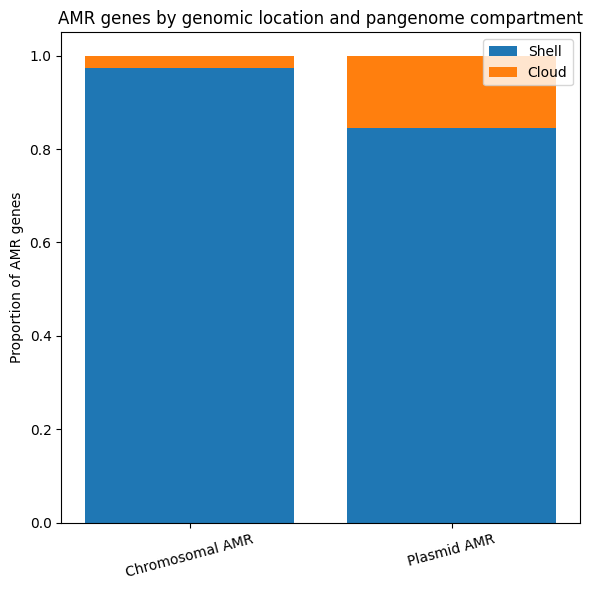

In [123]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Chromosomal AMR", "Plasmid AMR"]

shell_vals = [2196/2255, 3542/4191]
cloud_vals = [59/2255, 649/4191]

x = np.arange(len(labels))

plt.figure(figsize=(6,6))

plt.bar(x, shell_vals, label="Shell")
plt.bar(x, cloud_vals, bottom=shell_vals, label="Cloud")

plt.xticks(x, labels, rotation=15)
plt.ylabel("Proportion of AMR genes")
plt.title("AMR genes by genomic location and pangenome compartment")

plt.legend()
plt.tight_layout()
plt.show()


In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Build proportion matrix
heatmap_df = pd.DataFrame({
    "Shell": [2196/2255, 3542/4191],
    "Cloud": [59/2255, 649/4191]
}, index=["Chromosome", "Plasmid"])

heatmap_df


,Shell,Cloud
Chromosome,0.973836,0.026164
Plasmid,0.845144,0.154856


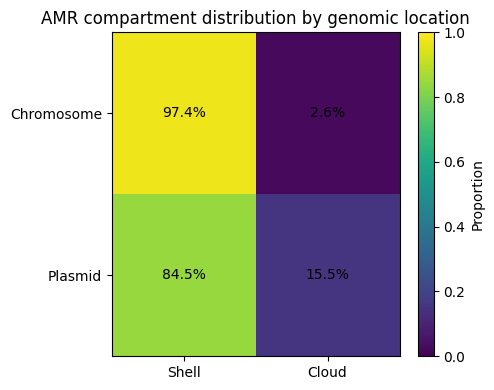

In [125]:
plt.figure(figsize=(5,4))

im = plt.imshow(heatmap_df, aspect="auto", vmin=0, vmax=1)


plt.xticks(range(len(heatmap_df.columns)), heatmap_df.columns)
plt.yticks(range(len(heatmap_df.index)), heatmap_df.index)

# Add percentage labels inside cells
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        value = round(heatmap_df.iloc[i, j]*100, 1)
        plt.text(j, i, f"{value}%", ha='center', va='center')

plt.title("AMR compartment distribution by genomic location")
plt.colorbar(im, label="Proportion")

plt.tight_layout()
plt.show()


In [126]:
final_summary.to_csv("AMR_mobility_summary_table.csv", index=False)

heatmap_df.to_csv("AMR_plasmid_compartment_proportions.csv")

gff_full.to_csv("Integrated_AMR_plasmid_dataset.csv", index=False)
